**Цель проекта:** Обучить модель классифицировать комментарии на позитивные и негативные.

**Метрика качества:** *F1* не меньше 0.75. 

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/4179c69cf1dde8418c4593177521847e862e7df8)

**Описание данных:** В распоряжении набор данных с разметкой о токсичности правок. Данные находятся в файле `toxic_comments.csv`.
Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

### Подготовка данных

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.4 MB/s 
     |████████████████████████████████| 6.6 MB 50.5 MB/s 
     |████████████████████████████████| 596 kB 12.0 MB/s 
     |████████████████████████████████| 86 kB 1.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 7.3 MB/s 
     |████████████████████████████████| 287 kB 55.4 MB/s 


In [ ]:
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
import contractions
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from sklearn.metrics import f1_score, roc_curve, precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import precision_score, recall_score
from sklearn import metrics

import torch
import transformers

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data = pd.DataFrame()
try:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')
except:
    pass

display(data.info())
display('----------NaN-----------', data.isna().sum())
display('-------DUPLICATES-------', data.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


None

'----------NaN-----------'

text     0
toxic    0
dtype: int64

'-------DUPLICATES-------'

0

,proportion,total
0,0.898,143346
1,0.102,16225


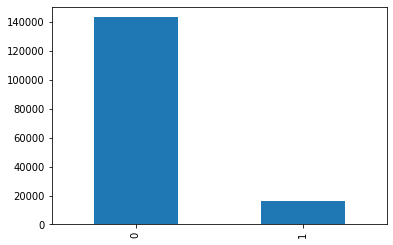

In [ ]:
# Дисбаланс классов

display(pd.DataFrame({'proportion': round(data['toxic'].value_counts(normalize = True), 3), 'total': data['toxic'].value_counts(normalize = False)}))

data['toxic'].value_counts(normalize = False).plot(kind = 'bar')
plt.show()

In [ ]:
# замена сокращений

data['clear_text'] = data['text'].apply(lambda x: contractions.fix(x))
#data['clear_text'].sample(15, random_state=12345)

In [ ]:
# функция для очистки текста от лишних символов
clear_text = lambda x: ' '.join(re.sub(r'[^a-zA-Z]', ' ', x).split())


data['clear_text'] = data['clear_text'].apply(lambda x: clear_text(x)) # Что лучше apply или transform ???
#data['clear_text'].sample(15, random_state=12345)

In [ ]:
lemmatizer = WordNetLemmatizer()


# функция для лемматизации текста
lemm_text = lambda x: ' '.join([lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x)])


data['clear_text'] = data['clear_text'].transform(lambda x: lemm_text(x))
data['clear_text'].sample(15, random_state=12345)

146790    Ahh shut the fuck up you douchebag sand nigger...
2941      REPLY There is no such thing a Texas Commerce ...
115087    Reply Hey you could at least mention Jasenovac...
48830                 That Is fine there is no deadline chi
136034    DYK nomination of Mustarabim Hello Your submis...
121992    Sockpuppetry case You have been accused of soc...
37282     Judging by what I have just read in an article...
64488     Todd and Copper In the first film they were li...
16992     You have been blocked from editing for a perio...
138230    decline Can not find evidence of block either ...
119101    Would you like to vote in that case If yes ple...
133505    Mmmm yes a pint of palestinian blood would be ...
149283                                        Talkback talk
40877     I guess I will leave it for now If someone els...
25778     Lab created Alexandrite Chrysoberyl Synthetic ...
Name: clear_text, dtype: object

In [ ]:
# Разбиение на выборки

X = data['clear_text']
y = data['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 12345, stratify = y)

sets = [X_train, X_test, y_train, y_test]
for _ in sets:
    print(_.shape)

(127656,)
(31915,)
(127656,)
(31915,)


In [ ]:
# стоп слова
stopwords = set(stopwords.words('english'))

# важность слов в мешке
count_tf_idf = TfidfVectorizer(stop_words=stopwords)#, ngram_range=(1, 1))

# обучающие признаки
corpus_train = X_train.values.astype('U') 
tf_idf_train = count_tf_idf.fit_transform(corpus_train) # fit_transform
print("Размер матрицы TRAIN:", tf_idf_train.shape)

# тестовые признаки
corpus_test = X_test.values.astype('U') 
tf_idf_test = count_tf_idf.transform(corpus_test) # transform
# fit_transform сделает разное количество фич и на трейне нельзя будет сделать предикт
print("Размер матрицы TEST:", tf_idf_test.shape)


Размер матрицы TRAIN: (127656, 143517)
Размер матрицы TEST: (31915, 143517)


In [ ]:
# # Баланс классов до апсемплинга
# y_train.value_counts(normalize = True) 

In [ ]:
# # Апсемплинг
# ros = RandomOverSampler(random_state = 12345)
# X_train_ros, y_train_ros = ros.fit_resample(tf_idf_train, y_train)
# print(X_train_ros.shape, y_train_ros.shape)

In [ ]:
# # Баланс классов после апсемплинга
# y_train_ros.value_counts(normalize = True)

### Логистическая регрессия

In [ ]:
from imblearn.pipeline import make_pipeline, Pipeline

model = Pipeline([
    ('oversampler', RandomOverSampler(random_state = 12345)),
    ('estimator', LogisticRegression(random_state=12345, class_weight = 'balanced'))
])

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

kf = KFold(n_splits=5, random_state=12345, shuffle=True)

param_grid = [{'estimator__penalty': ['l1', 'l2'],
        'estimator__C': [3.5, 20],
        'estimator__max_iter': [10, 20],
        'estimator__solver': ['liblinear']}]

gs = GridSearchCV(model, param_grid=param_grid, 
                   cv = kf, scoring='f1',
                   verbose=True, n_jobs=-1)


best_log_model = gs.fit(tf_idf_train, y_train)
print('best parameters', best_log_model.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
best parameters {'estimator__C': 3.5, 'estimator__max_iter': 10, 'estimator__penalty': 'l2', 'estimator__solver': 'liblinear'}


In [ ]:
# log_model = LogisticRegression(random_state = 12345, solver = 'liblinear', class_weight = 'balanced')
# log_model.fit(X_train_ros, y_train_ros)
# log_scores = cross_val_score(log_model, X_train_ros, y_train_ros, scoring = 'f1', cv = 5, n_jobs = -1)

print('--------LogisticRegression--------')
predictions_train = best_log_model.predict(tf_idf_train)
print('F1 score train:', round(f1_score(y_train, predictions_train), 2))

predictions_test = best_log_model.predict(tf_idf_test)
print('F1 score test: ', round(f1_score(y_test, predictions_test), 2))

--------LogisticRegression--------
F1 score train: 0.9
F1 score test:  0.77


Text(0.5, 15.0, 'Predicted class')

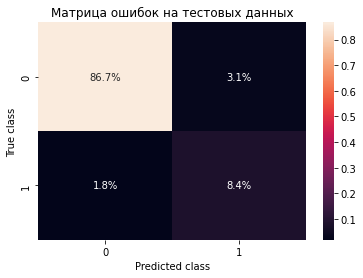

In [ ]:
# матрица ошибок

cnf_matrix = metrics.confusion_matrix(y_test, predictions_test)
ax = plt.axes()
sns.heatmap(cnf_matrix/np.sum(cnf_matrix), annot=True, fmt='.1%', ax = ax)
ax.set_title('Матрица ошибок на тестовых данных')
plt.ylabel('True class')
plt.xlabel('Predicted class')


In [ ]:
log_probabilities_one = best_log_model.predict_proba(tf_idf_test)[:,1]

In [ ]:
# Попытаемся улучшить f1 меру за счет изменения порога классификации
# Переберем значения порогов от 0 до 0.7 с шагом 0.02

best_result = 0
best_threshold = 0 
best_precision = 0
best_recall = 0
for threshold in np.arange(0, 0.7, 0.02):
    # Чтобы найти нужный класс, оператором > сравнить значения вероятностей класса «1» с порогом
    predict = log_probabilities_one > threshold # model.predict(features_valid)
    precision = precision_score(y_test, predict)
    recall = recall_score(y_test, predict)

    result = f1_score(y_test, predict)
    if result > best_result:
        best_result = result
        best_threshold = threshold 
        best_precision = precision
        best_recall = recall
print('----------test----------')
print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}".format(
        best_threshold, best_precision, best_recall))
print("f1_score:", best_result)

----------test----------
Порог = 0.66 | Точность = 0.808, Полнота = 0.777
f1_score: 0.7922690131992457


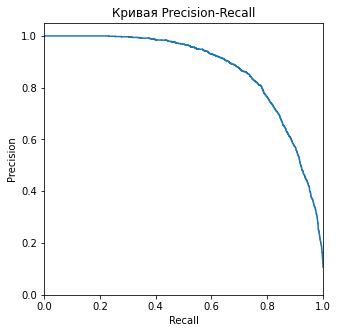

In [ ]:
# pr кривая

precision, recall, thresholds = precision_recall_curve(y_test, log_probabilities_one)

plt.figure(figsize=(5, 5))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show()

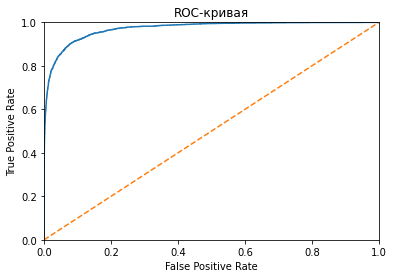

In [ ]:
# roc кривая

fpr, tpr, thresholds = roc_curve(y_test, log_probabilities_one)
plt.figure()
plt.plot(fpr, tpr)

# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

### Bert

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda", 1)
    print('GPU avaliable')
else:
    device = torch.device("cpu")
    print("GPU Unavaliable")

GPU avaliable


In [ ]:
batch_1 = data[:20000]

In [ ]:
import transformers as ppb
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# токенизируем текст
tokenized = batch_1['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, padding=True, truncation=True, max_length=512)))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

np.array(padded).shape

(20000, 512)

In [ ]:
# создадим маску для важных токенов
attention_mask = np.where(padded != 0, 1, 0)

print(attention_mask.shape)

(20000, 512)


In [ ]:
from tqdm import notebook # наглядно показать индикатор прогресса


# Сделаем цикл по батчам
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
      # Преобразуем данные в формат тензоров 
      batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).cuda()
      # преобразуем маску
      attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).cuda()
        
				
				# укажем, что градиенты не нужны
      with torch.no_grad():
          # Чтобы получить эмбеддинги для батча,
          # передадим модели данные и маску:
          model.cuda()
          batch_embeddings = model(batch, attention_mask=attention_mask_batch)
      
      # Из полученного тензора извлечём нужные элементы
      # и добавим в список всех эмбеддингов:
      # преобразуем элементы методом numpy() к типу numpy.array
      embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())
      del batch
      del attention_mask_batch
      del batch_embeddings

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
# Соберём все эмбеддинги в матрицу признаков
features = np.concatenate(embeddings)
target = batch_1['toxic']
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.5)

# модель
lr = LogisticRegression(class_weight='balanced', penalty='l1', solver='liblinear', random_state=12345)
lr.fit(X_train, y_train)

scores = cross_val_score(lr, X_train, y_train, scoring='f1', n_jobs=-1)
final_score = scores.mean()
print(final_score)


0.6352032675157062


In [ ]:
predict = lr.predict(X_test)
predict.shape 

(10000,)

In [ ]:
f1_score(y_test, predict)

0.6476841305998482